In [1]:
import pyodbc
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MaxAbsScaler

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Clustering 1-2-23.csv', delimiter= ";")
df = df[(df["Letra cluster"] == "A") | (df["Letra cluster"] == "B")]
df_10_ag = df[df["Distrito-Nombretipozona"] == '10-Artes graficas']
df_10_may = df[df["Distrito-Nombretipozona"] == '10-Mayorista']

In [ ]:
df_10_may

In [2]:
def df_cliente(nit_cliente, fecha_final):
    # Conexion al dwh
    cnxn = pyodbc.connect(
        driver='{SQL Server}',
        server='192.168.100.58',
        uid='bilectura',
        pwd='D1sp@p3l3s')
    cursor = cnxn.cursor()

    # Codigo SQL para cargar del dwh
    codigo_SQL = f"SELECT DATEFROMPARTS(VTAANO, VTAMES, 1) AS 'Fecha', SUM(VTAVLRVTA) AS 'Ventas' FROM V_VTA_VTAHEC WHERE CONCAT(CONCAT(VTANIT, '-'), VTASUC) = '{nit_cliente}' AND VTAFCH < '{fecha_final}' GROUP BY DATEFROMPARTS(VTAANO, VTAMES, 1)"

    #Carga de la data desde el dwh de Dispapeles y se guarda en df
    cursor.execute(codigo_SQL)
    rows = cursor.fetchall()
    df_SQL = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])
    df_SQL["Ventas"] = df_SQL["Ventas"].astype(int)
    df_SQL["Fecha"] = pd.to_datetime(df_SQL["Fecha"])
    df_SQL = df_SQL.set_index("Fecha")

    return df_SQL

In [3]:
def entrenar_arima(p, d, q, data, order_by, normalize= True):

    dict = []

    #definicion de cantidad de parametros del modelo ARIMA
    param_grid = [(p_p, d_d, q_q) for p_p in range(p) for d_d in range(d) for q_q in range(q)]

    print(f"Se van a correr {len(param_grid)} configuraciones del tipo {p, d, q}")

    if normalize == False:
        data_tf = data
    else:
        scaler = MaxAbsScaler()
        data_tf = scaler.fit_transform(data)
    
    for n, param in enumerate(param_grid):
        try:
            n_train = int(round(data_tf.shape[0] * 0.8, 0))
        
            # Split data_tf into training and testing sets
            train = data_tf[:n_train]
            test = data_tf[n_train:]

            model = ARIMA(train, order= param_grid[n])
            model_fit = model.fit()
        
            # make predictions
            predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

            # Evaluate the performance of the model using metrics such as mean absolute error (MAE) and mean squared error (MSE)
            mae = mean_absolute_error(test, predictions)
            mse = mean_squared_error(test, predictions)
            r2 = r2_score(test, predictions)
            mape = mean_absolute_percentage_error(test, predictions)

            dict.append({
                        "param": param_grid[n],
                        "mae": mae,
                        "mse": mse,
                        "r2": r2,
                        "mape": mape
                        })

        except:
            continue
    
    # Tabla de resultados de mejor modelo
    results = pd.DataFrame(dict).sort_values(order_by)
    best_param = results.iloc[0,0]

    # Fit del mejor modelo
    train = data_tf[:n_train]
    test = data_tf[n_train:]
    model_best = ARIMA(train, order= best_param)
    model_fit_best = model_best.fit()

    # make predictions
    predictions_norm = model_fit_best.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    predictions_norm = pd.DataFrame(predictions_norm)
    predictions_best = scaler.inverse_transform(predictions_norm)

    # Mensaje de salida
    print(" ")
    if normalize == True:
        print(f'La mejor configuracion con datos normalizados es {best_param} ordenado por {order_by}')
    else:
        print(f'La mejor configuracion sin normalizar es {best_param} ordenado por {order_by}')
    print(" ")
    print(results.iloc[0])

    return results, best_param, predictions_best


In [4]:
def plot_best_model(data_orig, data_pred):
    
    n_train = int(round(data_orig.shape[0] * 0.8, 0))
        
    # Split data into training and testing sets
    train = data_orig[:n_train]
    test = data_orig[n_train:]
    
    plt.figure(figsize=(12, 7))
    plt.plot(data_orig.values, label= 'Realidad', marker='x', markersize=4, markerfacecolor='blue')
    plt.plot(np.arange(len(data_orig) - len(test), len(data_orig)), data_pred, label= 'Prediccion', marker='o', markersize=2, color='red', linestyle='dashed')
    plt.title(f'Prediccion vs Realidad')
    plt.legend()
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.tight_layout()
    plt.show()

In [145]:
def predecir_cliente(nit_cliente, fecha_final, n_meses, param, alpha, normalize= True):
    
    df_SQL = df_cliente(nit_cliente= nit_cliente, fecha_final= fecha_final)

    scaler = MaxAbsScaler()
    if normalize == True:
        data_tf = scaler.fit_transform(df_SQL)
    else:
        data_tf = df_SQL

    # Creacion del modelo ARIMA
    model = ARIMA(data_tf, order= (param))
    model_fit = model.fit()

    if normalize:
        forecast = model_fit.get_forecast(steps= n_meses, alpha= alpha)
        predictions_norm = forecast.predicted_mean.reshape(-1,1)
        interv_conf_norm = forecast.conf_int()
        predictions = scaler.inverse_transform(predictions_norm)
        interv_conf = scaler.inverse_transform(interv_conf_norm)

    else:
        forecast = model_fit.get_forecast(steps= n_meses, alpha= alpha)
        predictions_norm = forecast.predicted_mean
        interv_conf = forecast.conf_int()
        predictions = predictions_norm

    # Estetica de la grafica
    plt.figure(figsize=(12, 7))
    plt.plot(df_SQL.iloc[-24:,:].values, label= 'Reales', marker='x', markersize=4, markerfacecolor='blue')
    plt.plot(np.arange(len(df_SQL.iloc[-24:,:]), len(df_SQL.iloc[-24:,:])+n_meses), predictions, label= 'Prediccion', marker='o', markersize=2, color='red', linestyle='dashed')
    plt.fill_between(np.arange(len(df_SQL.iloc[-24:,:]), len(df_SQL.iloc[-24:,:])+n_meses), interv_conf[:,0], interv_conf[:,1], color='k', alpha=.05)
    plt.title(f'Prediccion {n_meses} meses para cliente {nit_cliente} con conf: {param}')
    plt.legend()
    plt.xticks()
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.tight_layout()
    plt.show()

    # df con los valores predichos y el intervalo de confianza
    upper_intconf = interv_conf[:,1]
    lower_intconf = interv_conf[:,0]
    df_results = pd.DataFrame({"Prediccion": predictions[:, 0],
                                "upper_pred": upper_intconf,
                                "lower_pred": lower_intconf
                                })
    print(df_results)

In [ ]:
nit_cliente = "'800226417-1'"
# nit_cliente = "'900085929-1'"
# nit_cliente = "'900173543-1'"
# nit_cliente = "'800065396-1'"
fecha_final = "'2023-01-31'"

In [21]:
df_SQL = df_cliente(nit_cliente= "800065396-1", fecha_final= "2023-01-31")

In [147]:
results, best_param, predictions_best = entrenar_arima(p= 6, d= 6, q= 6, data= df_SQL, order_by= 'mape', normalize= True)

Se van a correr 216 configuraciones del tipo (6, 6, 6)
 
La mejor configuracion con datos normalizados es (0, 2, 1) ordenado por mape
 
param    (0, 2, 1)
mae       0.101306
mse       0.034022
r2       -0.259921
mape      0.144201
Name: 13, dtype: object


In [ ]:
plot_best_model(df_SQL, predictions_best)

In [148]:
results.head(6)

,param,mae,mse,r2,mape
13,"(0, 2, 1)",0.101306,0.034022,-0.259921,0.144201
6,"(0, 1, 0)",0.101941,0.034415,-0.274499,0.144959
79,"(2, 1, 1)",0.101716,0.033811,-0.252120,0.145615
87,"(2, 2, 3)",0.100902,0.032030,-0.186166,0.148661
155,"(4, 1, 5)",0.102747,0.032274,-0.195210,0.152041
7,"(0, 1, 1)",0.107528,0.036486,-0.351201,0.153889


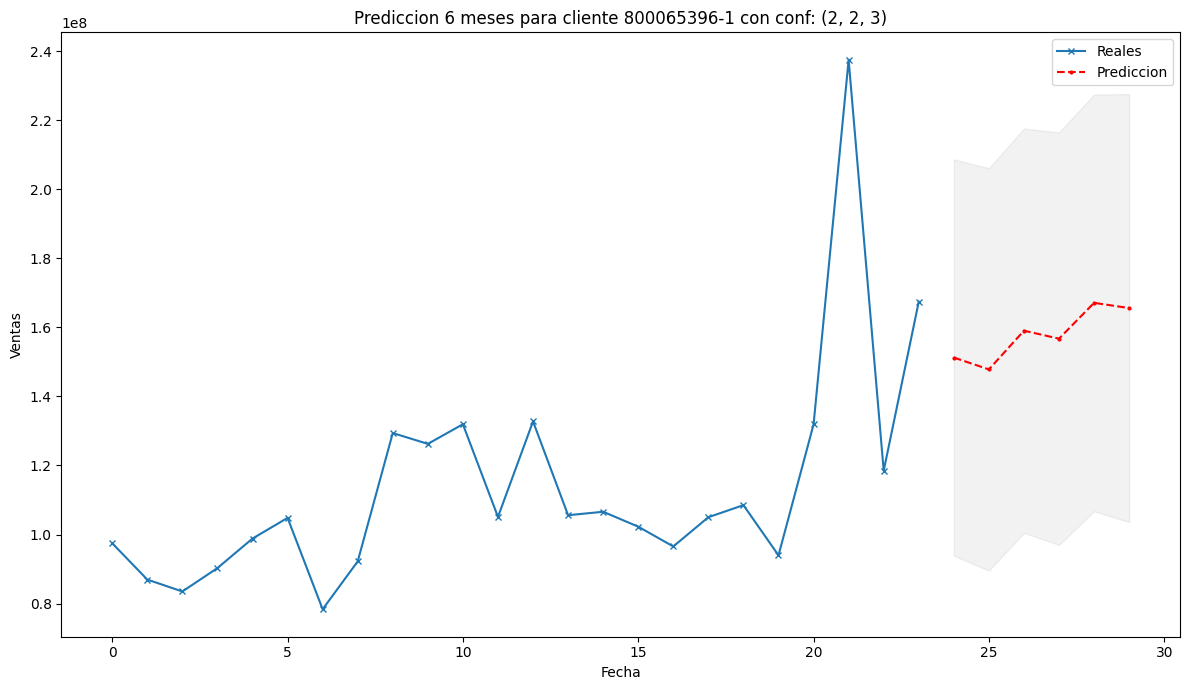

     Prediccion    upper_pred    lower_pred
0  1.512534e+08  2.086494e+08  9.385738e+07
1  1.478133e+08  2.060855e+08  8.954107e+07
2  1.590276e+08  2.175746e+08  1.004807e+08
3  1.567229e+08  2.164597e+08  9.698613e+07
4  1.670921e+08  2.274362e+08  1.067481e+08
5  1.655814e+08  2.275614e+08  1.036014e+08


In [149]:
predecir_cliente(nit_cliente= "800065396-1", fecha_final= "2023-01-31", n_meses= 6, param= (2,2,3), alpha= 0.01, normalize= True)